Track Comparison between WRF Simulations and IBTrACS.

This script is offered as an alternative to the 'CreateTracks.ncl' script.
The user needs to go to the 'user inputs' section and enter all the information required. 

Data for TC track is coming from:

    When automatic moving nest is employed in the WRF-real runs, the model dumps the vortex center
    location, with minimum mean sea-level pressure and maximum 10 m winds in standard out
    file (e.g. rsl.out.0000). Typing:

     grep ATCF rsl.out.0000 > ATCF_track.txt 

    Will produce a list of storm information at 15 minutes intervals and dump them into a text file.
    Manually covert them into a .csv for easy importing.

Data for the observed TC path comes from IBTrACS. The path for TC Alby has been manually extracted
from much a larger IBtracks spatial file that contains info on many many TCs

Note: This function requires the installation of 'contextily', which creates a nice basemap

    pip install --user contextily

This script is written in Jan. 2019 by Chad Burton.
The notebook was completed as a part of a graduate program at Geoscience Australia.

## User Inputs

In [87]:
#where is the ATCF track .csv?
TC_modelled_path_loc = 'Kenneth_ATCF_track_21-26.csv' #data/track_data/ATCF_track_alby_nudge_2domRun.csv'
#where is IBtracks spatial file?
IBtracks_loc = "Kenneth.shp" #data/spatial/alby_pt.shp"
#What attribute would you like to use to colour the plot (Pcentre, MaxWind)?
varname='Pcentre'
#What title would you like to give the plot and subsequent filename?
main_title =  'Kenneth_track' #alby_nudge_2domRun'
#what color ramp would you like?
cmap='rainbow'
#What should the the minimum value for the colorramp be?
vmin=10
#What should the the maximum value for the colorramp be?
vmax=50
#would you like to save the plot (default is False)?
export_plot = True
#where would you like the saved plot to be exported too?
output_loc = "C:/Users/Aston/Downloads/TC_Alby/TC_Alby/src/results/Ken_track/" #/nudging_runs/"


## plotting function

Run the following two cells and you'll have your plot

In [88]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import contextily as ctx

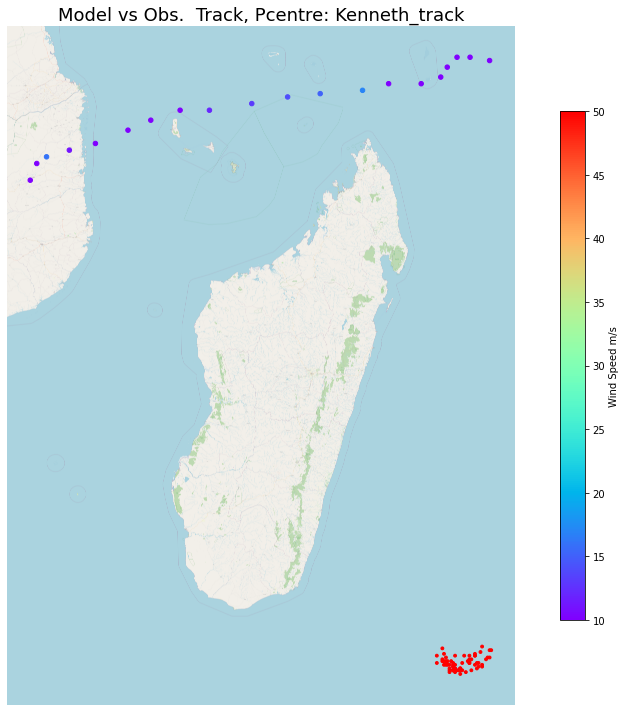

In [89]:
def trackComparisons(TC_modelled_path_loc, IBtracks_loc, varname,
                     main_title, output_loc, cmap='plasma', export_plot = False):
    """
    This function plots the WRF TC path against the plot in IBtracks
    """
    #bring in shapefile of IBTracks path
    obs_path = gpd.read_file(IBtracks_loc)
    #bring in the path from the modelled TC
    model_path = pd.read_csv(TC_modelled_path_loc, header=None, names=["NAME", "datetime", "lat", "long", "Pcentre", "MaxWind"])
    model_path = model_path.drop(columns=['NAME']) #drop the useless column
    #convert the windspeed to m/s (currently in knots) #original~ model_path['MaxWind'] = model_path['MaxWind']*0.51444
    model_path['MaxWind'] = model_path['MaxWind']*0.51444
    #get the extent of the modelled path to use for plotting
    xmin, xmax, ymin, ymax  = model_path['long'].min()-5, model_path['long'].max()+15,  model_path['lat'].min()-7, model_path['lat'].max()+7                       
    ##xmin, xmax, ymin, ymax  = (float(model_path['long'].min()-5, (float(model_path['long'].max()+15,  (float(model_path['lat'].min()-7, (float(model_path['lat'].max()+7
    #turn the model_path dataframe into a spatial object
    geometry = [Point(xy) for xy in zip(model_path.long, model_path.lat)]
    model_path = model_path.drop(['long', 'lat'], axis=1)
    crs = obs_path.crs
    model_path = gpd.GeoDataFrame(model_path, crs=crs, geometry=geometry)
     
    #convert projection of TC paths so they play nice with our basemap
    obs_path = obs_path.to_crs(epsg=3857)
    model_path = model_path.to_crs(epsg=3857)
    
    #helper function for generating basemap
    def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
        xmin, xmax, ymin, ymax = ax.axis()
        xmin, xmax, ymin, ymax = xmin-10, xmax+15, ymin-7, ymax+7
        basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
        ax.imshow(basemap, extent=extent, interpolation='bilinear')
        # restore original x/y limits
        ax.axis((xmin, xmax, ymin, ymax))
    
    #create the plots for the two TC paths
    ax = obs_path.plot(figsize=(13, 10), markersize=20, column=varname, cmap=cmap ,vmin=vmin, vmax=vmax)
    model_path.plot(ax=ax,column=varname, markersize=8, cmap=cmap,vmin=vmin, vmax=vmax)
    
    #create a colorbar for the TC paths to share
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cb=plt.colorbar(sm, shrink=0.75)
    
    #create the basemap
    #add_basemap(ax, zoom= 6, url=ctx.sources.ST_TERRAIN)
    ctx.add_basemap(ax, crs=obs_path.crs.to_string(), zoom=10, attribution="", source=ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.Stamen.Terrain) #OpenStreetMap.Mapnik) #Stamen.Terrain
    #source=ctx.providers.Stamen.Terrain )#url = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.url.ST_TERRAIN) #url=ctx.sources.ST_TERRAIN) #source=ctx.providers.Stamen.TonerLite)
    
    ## Modify the attribution (Remove copyright at the bottom left, set ....attribution="" )
    ##ctx.add_basemap(ax, zoom=11, attribution="Travel time data by Digital Geography Lab, Map Data © OpenStreetMap contributors", url=ctx.tile_providers.OSM_A)
    
    #tidy the plot
    ax.set_axis_off()
    plt.title("Model vs Obs.  Track, " + varname + ": " + main_title, fontsize=18)
    plt.tight_layout()
    
    cb.set_label('Wind Speed m/s', fontsize=10)
    #cb.set_label('SST $^\circ$C', fontsize=7)
    
    #export plot it that what the user wants
    if export_plot == True:
        plt.savefig(output_loc + main_title + "_" + varname + ".png", bbox_inches='tight')
        plt.savefig(output_loc + main_title + "_" + varname + ".svg", bbox_inches='tight')
        plt.savefig(output_loc + main_title + "_" + varname + ".tiff", bbox_inches='tight')
        plt.savefig(output_loc + main_title + "_" + varname + ".pdf", bbox_inches='tight')
trackComparisons(TC_modelled_path_loc = TC_modelled_path_loc,
                  IBtracks_loc = IBtracks_loc,
                  varname=varname,
                  main_title = main_title,
                  output_loc = output_loc,
                  cmap=cmap,
                  export_plot = export_plot)